# Neural network tuned with BOHB

## Importing

In [1]:
%cd ..
import hpbandster.core.nameserver as hpns
import hpbandster.core.result as hpres
from hpbandster.optimizers import BOHB
import hpbandster.visualization as hpvis
import logging
import pickle
logging.getLogger('hpbandster').setLevel(logging.DEBUG)
import matplotlib.pyplot as plt
sys.path.append("../")
from func.NN_HPO import PyTorchWorker
from func.load_data import prepare_dataloaders, load_data_from_file

c:\Users\saipr\Documents\Deep Learning\ws19\LCBench_DL


## Load + Prepare data

In [2]:
X_train, X_metafeatures_train, y_train, X_val, X_metafeatures_val, y_val, X_test, X_metafeatures_test, y_test    =   load_data_from_file("cached/six_datasets_lw.json", "cached/metafeatures_6.json")

Path to hyperparameters data:  c:\Users\saipr\Documents\Deep Learning\ws19\LCBench_DL/cached/six_datasets_lw.json
Path to metafeatures data:  c:\Users\saipr\Documents\Deep Learning\ws19\LCBench_DL/cached/metafeatures_6.json
==> Loading data...
==> No cached data found or cache set to False.
==> Reading json data...
==> Done.
Available datasets:  ['Fashion-MNIST', 'adult', 'higgs', 'jasmine', 'vehicle', 'volkert']
Train-Validation-Test split: 6000-2000-4000


In [3]:
train_tuple = (X_train, X_metafeatures_train, y_train)
validation_tuple = (X_val, X_metafeatures_val, y_val)
test_tuple = (X_test, X_metafeatures_test, y_test)

## Sanity test for out worker

In [4]:
working_dir = os.curdir
# minimum budget that BOHB uses
min_budget = 1
# largest budget BOHB will use
max_budget = 10

worker = PyTorchWorker(run_id='0', input_size=55, output_size=1, train_tuple= train_tuple, validation_tuple= validation_tuple, test_tuple= test_tuple)
configspace = worker.get_configspace()
worker.config = configspace
singleconfig = configspace.sample_configuration().get_dictionary()
print("Config: ", singleconfig)

Config:  {'batch_size': 6, 'dropout_rate': 0.6418992398945625, 'lr': 0.0335144382155294, 'num_layers': 3, 'optimizer': 'SGD', 'sgd_momentum': 0.6045650320725364}


In [5]:
res = worker.compute(config=singleconfig, budget=min_budget, working_directory=working_dir)
print(res)

Sequential(
  (fc1): Linear(in_features=55, out_features=37, bias=True)
  (dropout1): Dropout(p=0.6418992398945625, inplace=False)
  (relu1): ReLU()
  (fc2): Linear(in_features=37, out_features=19, bias=True)
  (dropout2): Dropout(p=0.6418992398945625, inplace=False)
  (relu2): ReLU()
  (fc3): Linear(in_features=19, out_features=1, bias=True)
)
{'loss': 0.021793069183397035, 'info': {'test accuracy': 0.041608039113082765, 'train accuracy': 0.020562982799019663, 'validation accuracy': 0.021793069183397035, 'model': 'Sequential(\n  (fc1): Linear(in_features=55, out_features=37, bias=True)\n  (dropout1): Dropout(p=0.6418992398945625, inplace=False)\n  (relu1): ReLU()\n  (fc2): Linear(in_features=37, out_features=19, bias=True)\n  (dropout2): Dropout(p=0.6418992398945625, inplace=False)\n  (relu2): ReLU()\n  (fc3): Linear(in_features=19, out_features=1, bias=True)\n)'}}


## BOHB parameters and variables

In [6]:
result_file = os.path.join(working_dir, 'bohb_LC_result.pkl')
nic_name = 'lo0'
port = 0
run_id = 'bohb_run_1'
n_bohb_iterations = 15

In [7]:
try:
    try:
        host = hpns.nic_name_to_host(nic_name)
    except ValueError as e:
        host = "localhost"
        print(e)
        print("ValueError getting host from nic_name {}, "
              "setting to localhost.".format(nic_name))    
    
    ns = hpns.NameServer(run_id=run_id, host=host, port=port,
                         working_directory=working_dir)
    ns_host, ns_port = ns.start()

    # Start local worker
    w = PyTorchWorker(run_id=run_id, host=host, nameserver=ns_host,
                      nameserver_port=ns_port, timeout=120, input_size=55, output_size=1, train_tuple= train_tuple, validation_tuple= validation_tuple, test_tuple= test_tuple)
    w.run(background=True)

    # Run an optimizer
    bohb = BOHB(configspace=worker.get_configspace(),
                run_id=run_id,
                host=host,
                nameserver=ns_host,
                nameserver_port=ns_port,
                min_budget=min_budget, max_budget=max_budget)

    result = bohb.run(n_iterations=n_bohb_iterations)
    print("Write result to file {}".format(result_file))
    with open(result_file, 'wb') as f:
        pickle.dump(result, f)
finally:
    bohb.shutdown(shutdown_workers=True)
    ns.shutdown()

0349325395707126, inplace=False)\n  (relu1): ReLU()\n  (fc2): Linear(in_features=37, out_features=19, bias=True)\n  (dropout2): Dropout(p=0.10349325395707126, inplace=False)\n  (relu2): ReLU()\n  (fc3): Linear(in_features=19, out_features=1, bias=True)\n)'}}
exception: None

11:45:28 job_callback for (13, 0, 1) started
11:45:28 DISPATCHER: Trying to submit another job.
11:45:28 job_callback for (13, 0, 1) got condition
11:45:28 DISPATCHER: jobs to submit = 0, number of idle workers = 1 -> waiting!
11:45:28 HBMASTER: Trying to run another job!
11:45:28 job_callback for (13, 0, 1) finished
11:45:28 start sampling a new configuration.
11:45:28 done sampling a new configuration.
11:45:28 HBMASTER: schedule new run for iteration 13
11:45:28 HBMASTER: trying submitting job (13, 0, 2) to dispatcher
11:45:28 HBMASTER: submitting job (13, 0, 2) to dispatcher
11:45:28 DISPATCHER: trying to submit job (13, 0, 2)
11:45:28 DISPATCHER: trying to notify the job_runner thread.
11:45:28 HBMASTER: job (

## Get best run

In [8]:
incumbent  = result.get_incumbent_id()  # get config_id of incumbent (lowest loss)
inc_run = result.get_runs_by_id(incumbent)[-1]  # get run with this config_id on highest budget
best_error, best_model, test_error = inc_run.loss, inc_run.info['model'], inc_run.info["test accuracy"]
print("The best model (config_id {}) has the lowest final error with {:.4f} and test error {:.4f}."
      .format(inc_run.config_id, best_error,test_error))
print(best_model)

The best model (config_id (3, 0, 0)) has the lowest final error with 0.0079 and test error 0.0268.
Sequential(
  (fc1): Linear(in_features=55, out_features=48, bias=True)
  (dropout1): Dropout(p=0.023152183717430563, inplace=False)
  (relu1): ReLU()
  (fc2): Linear(in_features=48, out_features=41, bias=True)
  (dropout2): Dropout(p=0.023152183717430563, inplace=False)
  (relu2): ReLU()
  (fc3): Linear(in_features=41, out_features=34, bias=True)
  (dropout3): Dropout(p=0.023152183717430563, inplace=False)
  (relu3): ReLU()
  (fc4): Linear(in_features=34, out_features=27, bias=True)
  (dropout4): Dropout(p=0.023152183717430563, inplace=False)
  (relu4): ReLU()
  (fc5): Linear(in_features=27, out_features=20, bias=True)
  (dropout5): Dropout(p=0.023152183717430563, inplace=False)
  (relu5): ReLU()
  (fc6): Linear(in_features=20, out_features=13, bias=True)
  (dropout6): Dropout(p=0.023152183717430563, inplace=False)
  (relu6): ReLU()
  (fc7): Linear(in_features=13, out_features=6, bias=Tr

In [9]:
all_runs = result.get_all_runs()
id2config = result.get_id2config_mapping()
print('A total of %i unique configurations where sampled.' % len(id2config.keys()))
print('A total of %i runs where executed.' % len(result.get_all_runs()))
best_config = id2config[incumbent]['config']
print(best_config)

A total of 75 unique configurations where sampled.
A total of 100 runs where executed.
{'batch_size': 3, 'dropout_rate': 0.023152183717430563, 'lr': 0.0017383886207955662, 'num_layers': 8, 'optimizer': 'Adam'}


## Visualizations

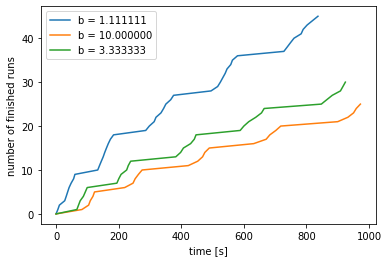

11:49:08 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000226545E73A0>
11:49:08 Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000226545E73A0> on colorbar
11:49:08 Setting pcolormesh


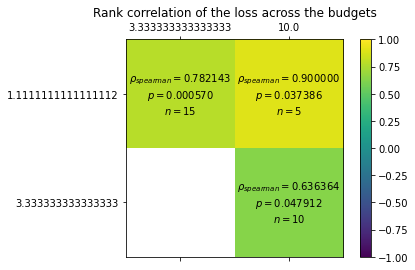

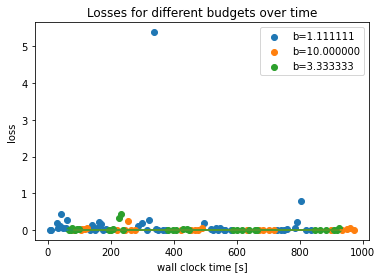

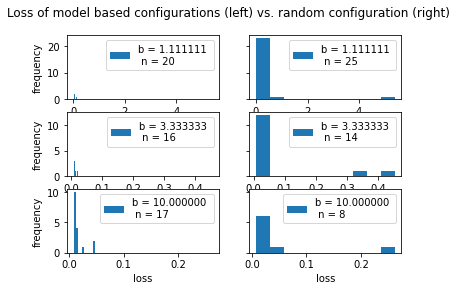

In [11]:
hpvis.finished_runs_over_time(all_runs, show=True);
hpvis.correlation_across_budgets(result, show=True);
hpvis.losses_over_time(all_runs, show=True);
hpvis.performance_histogram_model_vs_random(all_runs, id2config, show=True);
plt.show()